# Sensitivity analysis </a><a name='top'>

In this notebook we try to study the sensivity of our model to critical parameters: std_threshold (standard deviation threshold above which the curve is considered to have strong variations, thus to be in a snow event), and time_window_std (size of the rolling window to compute standard deviation).

Parameters are defined in the file **parameter.py**, to be adjusted before launching the notebook, but additional information must be filled in in [**this section**](#fill-in). Once these two sections are filled-in, the whole notebook may be run.

In [1]:
# TODO should the tests be carried out on several geographical points?

## Imports and functions

In [2]:
%run little_awk_functions.py
%run parameters.py

In get_met_forcing() - Warning: check the format of your file corresponds to the indices given in the functions (wind speed 5, surface temperature 7, time 0).


## Define parameters </a><a name='fill-in'>

In [3]:
# Dataset

name_of_data_set = 'pit_1_2023.nc'

# Figure parameters

save_figures = False
directory_to_save_figs_in = '/home/mabonnet/github/MB_little_awk/finalized/Results_pits_2023/'
fig_name = 'pit_1_sensitivity_stdev_large.png'

In [4]:
# Define all the values the parameter of interest will take

default_value_of_tw = 25
# range_of_tw_variation = [23, 25, 27]
range_of_tw_variation = [13, 25, 37]

default_value_of_st = 0.018
# range_of_st_variation = [round(default_value_of_st-0.004, 3), round(default_value_of_st-0.002, 3), round(default_value_of_st, 3), round(default_value_of_st+0.002, 3), round(default_value_of_st+0.004, 3)]
range_of_st_variation = [0.0001, round(default_value_of_st-0.005, 3), round(default_value_of_st, 3), round(default_value_of_st+0.005, 3), round(default_value_of_st+0.015, 3)]


[Back to top section](#top)

## Clean dataset and derive other parameters

In [5]:
# Pre-processing to get clean data

data_set_used = xr.open_dataset(name_of_data_set)

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7, y_span=7)
median_time_filtering(data_set_used, 11)

# Add the summer surface to the dataset

define_summer_surface(data_set_used, start_summer_surface, end_summer_surface)

# Redefine the zero of the dataset

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['summer_surface']


---> Median filtering in space with a window [7, 7]
---> Median filtering in time with a window of 11
---> Summer surface defined based on scans from 2022-10-07 to 2022-10-15


In [6]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

data_start_date = pd.to_datetime(data_set_used.time.values[0])

nb_iterations = int(data_duration_in_s/dt + 1)

In [7]:
# Create comparable data between lidar and simulation (same timestamps)

lidar_height_array = []
keep_simul_times_indices = []    # indices of the timestamps to keep in the simulation data, that are comparable to the lidar data
                                # given that dt << lidar scans time period, there are no repetitions in keep_simul_times_indices

ignore = np.isnan(data_set_used.snow_surface.isel(x=x_sel, y=y_sel))     # do not take into account the nan values in the dataset

for index in range(len(data_set_used.time.values)):
        lidar_time_in_s = float(data_set_used.time.values[index]) / 1000000000 - float(data_set_used.time.values[0]) / 1000000000
        if lidar_time_in_s < nb_iterations*dt and not ignore[index]:
            lidar_height_array.append(data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=index))

            index_of_closest_time_in_simul = int(lidar_time_in_s//dt + round((lidar_time_in_s%dt)/dt))
            keep_simul_times_indices.append(index_of_closest_time_in_simul)

lidar_height_array = np.array(lidar_height_array)

## Variation of parameters and evaluation of each model

In [8]:
# Initialize evaluation lists

result_list_rmse = []
result_list_stde = []
result_list_pcorr = []

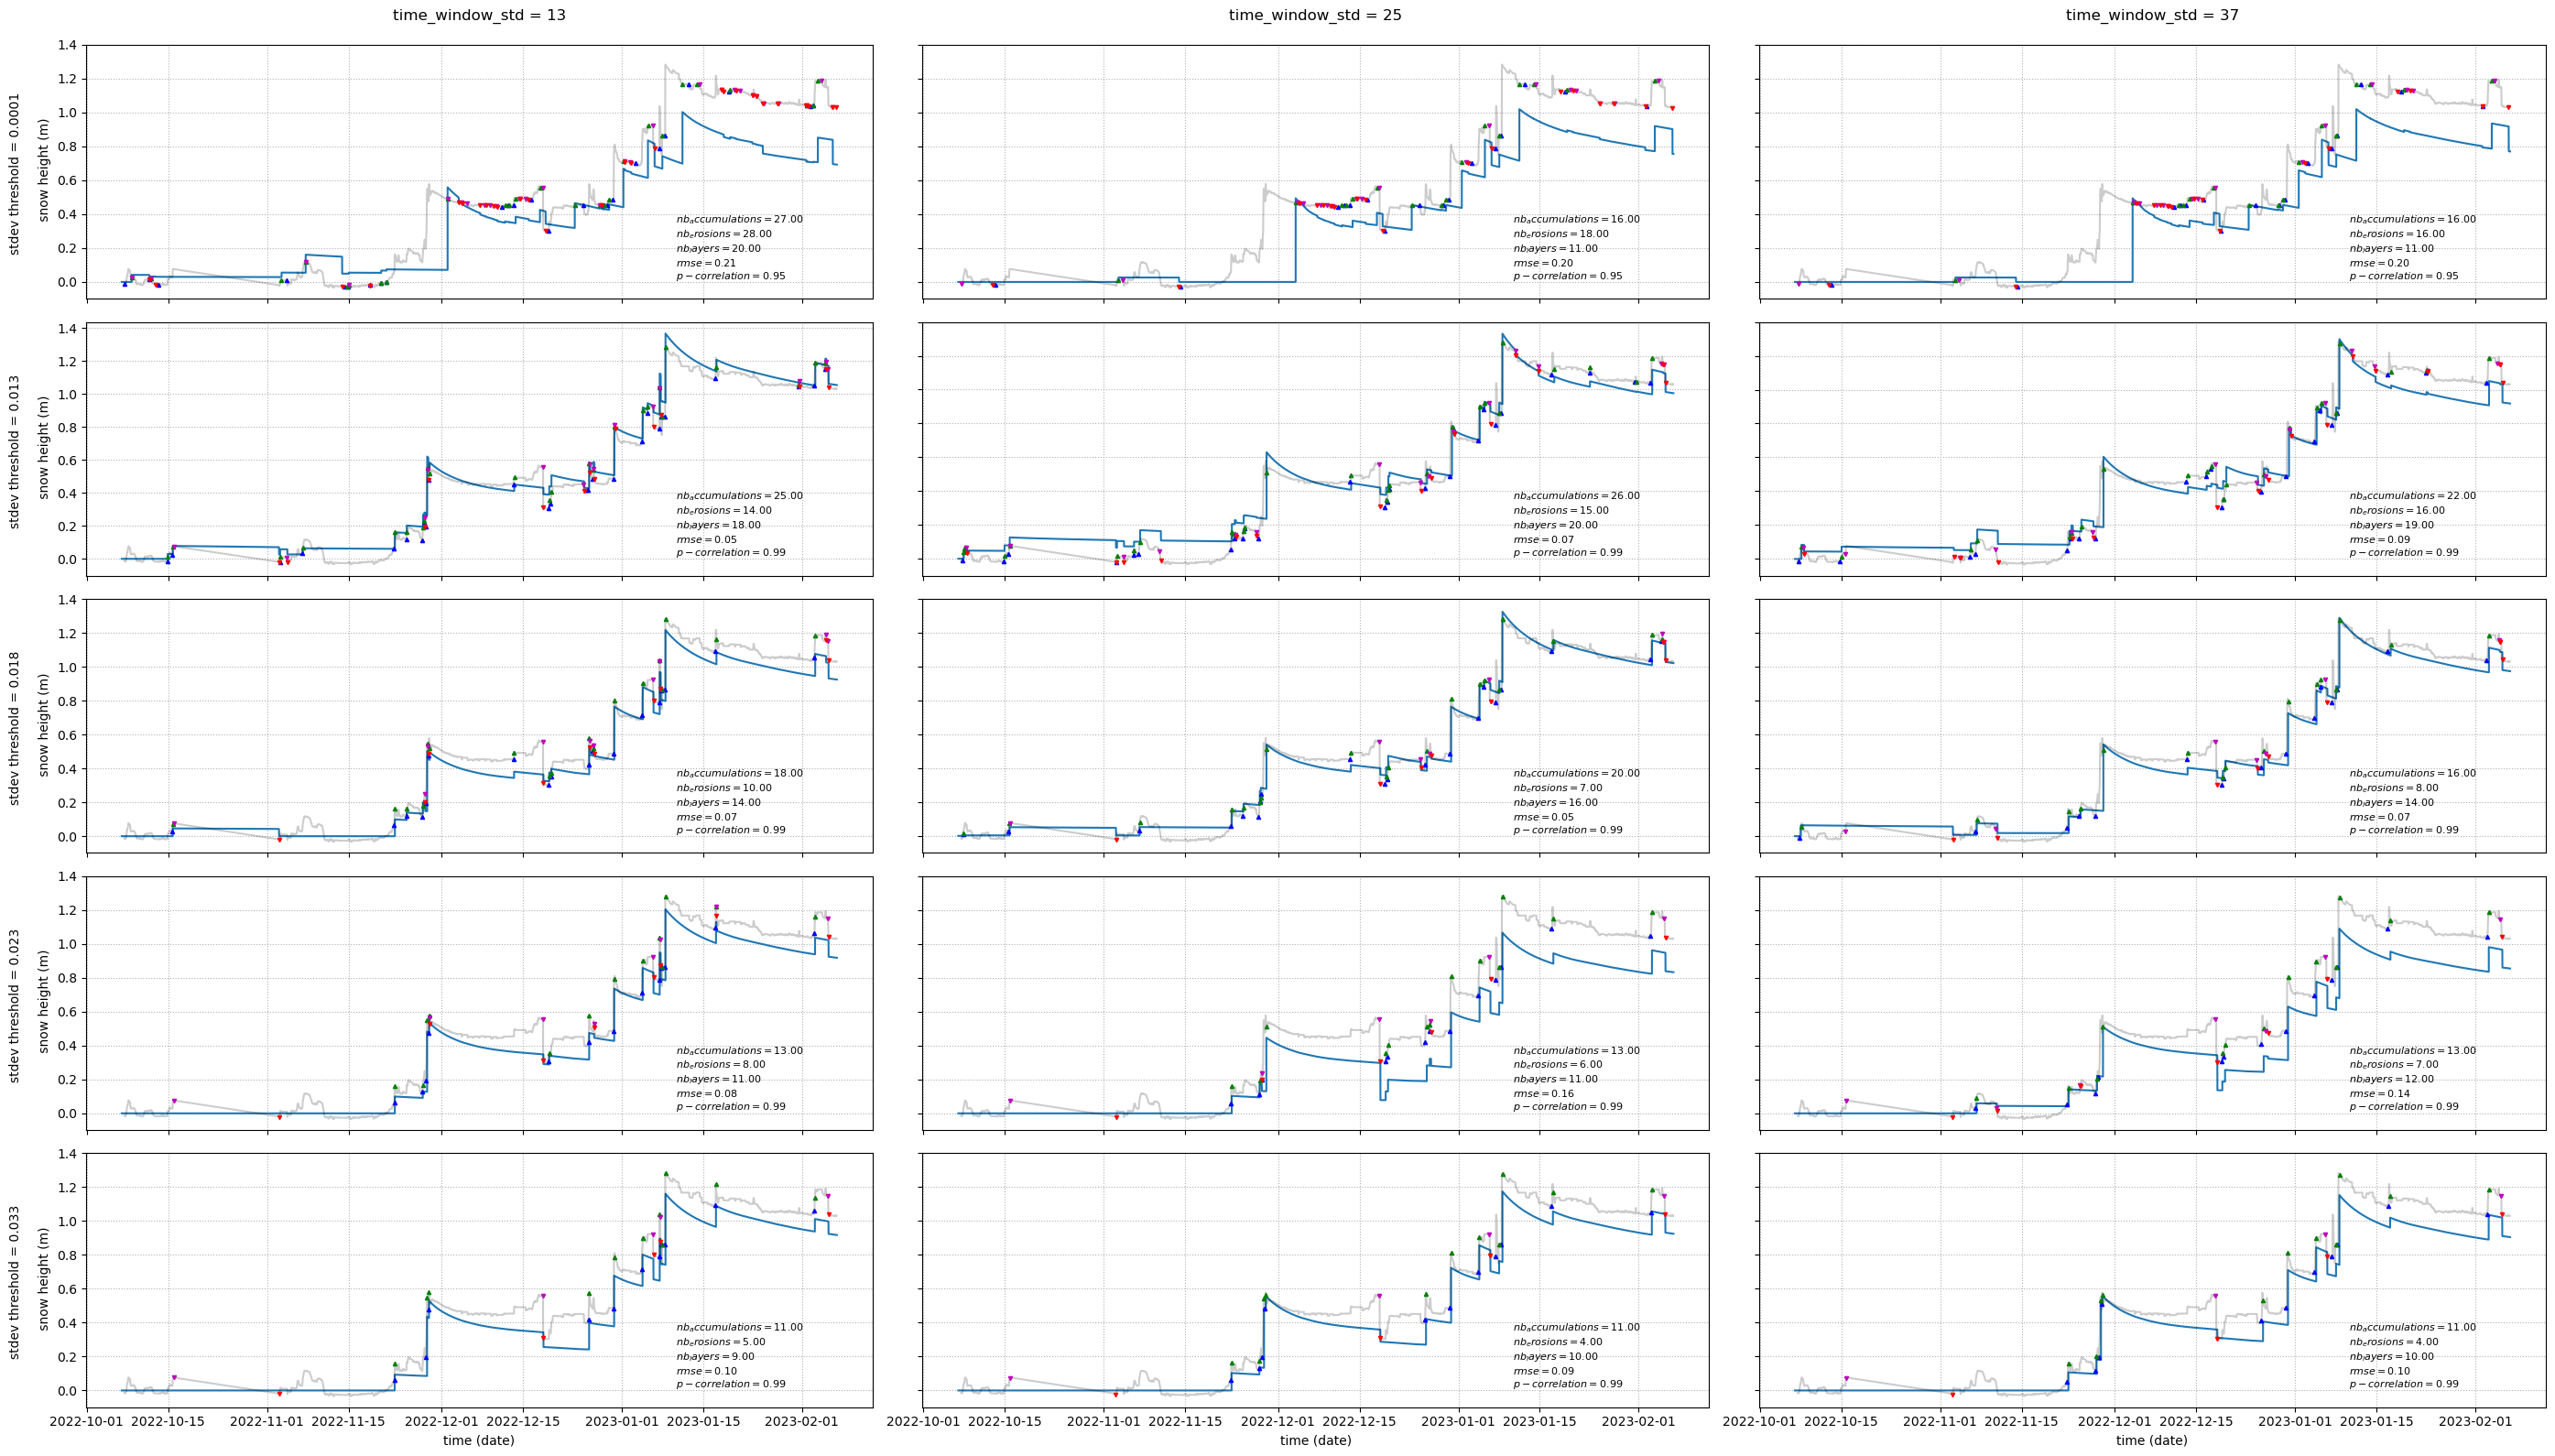

In [9]:
# Create figure

fig, axs = plt.subplots(5, 3, figsize=(28, 16))

for i in range(len(axs.flat)):
    axs.flat[i].set(xlabel='time (date)', ylabel='stdev threshold = ' + str(range_of_st_variation[i//len(range_of_tw_variation)]) + ' \n\n snow height (m)')
    axs.flat[i].label_outer()
    
axs[0,0].set_title('time_window_std = '+str(range_of_tw_variation[0]) + '\n')
axs[0,1].set_title('time_window_std = '+str(range_of_tw_variation[1]) + '\n')
axs[0,2].set_title('time_window_std = '+str(range_of_tw_variation[2]) + '\n')

# Loop on parameter values

for tw_index in range(len(range_of_tw_variation)):
    
    for st_index in range(len(range_of_st_variation)):
        
        # Events detection
        
        time_window_std = range_of_tw_variation[tw_index]
        std_threshold = range_of_st_variation[st_index]
    
        results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
        start_accumulation, start_erosion, end_accumulation, end_erosion = results[0], results[1], results[2], results[3]

        # Convert end times into more manageable orders of magnitude

        end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
        end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

        end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
        end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

        # Update variables at each timepoint

        snowpack = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp, met_wind_data=met_wind,
                                       met_time_data=met_time, fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve,
                                       erode_several_layers=simul_erode_several_layers, detect_ice=False)

        ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]
     
        # Define total_snow_depth
    
        simulation_times = pd.date_range(start=data_start_date,freq=str(dt)+'S',periods=nb_iterations)
        total_snow_depth = np.array([sum(depth_evolution[i][j] for j in range(max_nb_of_layers)) for i in range(len(depth_evolution))])
        total_snow_depth_comparable = np.array([sum(depth_evolution[i][j] for j in range(max_nb_of_layers)) for i in range(len(depth_evolution)) if i in keep_simul_times_indices])
        
        nb_layers_detected = len([i for i in depth_evolution[-1] if i != 0])
    
        # Plot results to compare
            
        axs[st_index, tw_index].plot(simulation_times, total_snow_depth, label='simulated snow depth')
        if st_index != 0:
            axs[st_index, tw_index].set_title(None)
    
        axs[st_index, tw_index].plot(data_set_used.time.values, data_set_used.isel(x=x_sel, y=y_sel).snow_surface, c='k', alpha=0.2)

        axs[st_index, tw_index].plot(data_set_used.time.values[start_accumulation], data_set_used.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface, c='b', marker='^', markersize=3, linestyle='None', label='start accum.')
        axs[st_index, tw_index].plot(data_set_used.time.values[end_accumulation], data_set_used.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface, c='g', marker='^', markersize=3, linestyle='None', label='end accum.')
        axs[st_index, tw_index].plot(data_set_used.time.values[start_erosion], data_set_used.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface, c='m', marker='v', markersize=3, linestyle='None', label='start erosion')
        axs[st_index, tw_index].plot(data_set_used.time.values[end_erosion], data_set_used.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface, c='r', marker='v', markersize=3, linestyle='None', label='end erosion')

        axs[st_index, tw_index].grid(ls=':')
        axs[st_index, tw_index].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
        
        # Evaluate similarity between simulated and measured curves
    
        result_eval_rmse = rmse_measure(total_snow_depth_comparable, lidar_height_array)
        result_eval_stde = stderr_measure(total_snow_depth_comparable, lidar_height_array)
        result_eval_pcorr = p_correl_measure(total_snow_depth_comparable, lidar_height_array)
        
        # Add text box with extra info
        
        textstr = '\n'.join((r'$nb_accumulations=%.2f$' % (len(start_accumulation), ), r'$nb_erosions=%.2f$' % (len(start_erosion), ), r'$nb_layers=%.2f$' % (nb_layers_detected, ),
                             r'$rmse=%.2f$' % (result_eval_rmse, ), r'$p-correlation=%.2f$' % (result_eval_pcorr, )))
        axs[st_index, tw_index].text(0.75, 0.2, textstr, horizontalalignment='left', verticalalignment='center', transform=axs[st_index, tw_index].transAxes, fontsize=8)

        plt.tight_layout()


In [10]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + fig_name)